# **Kidney Cancer Challenge**

## Inizializzazione e import delle librerie


*   Collegamento a Google Drive e import delle librerie necessarie



In [ ]:
# Before running the script, reset the runtime to factory reset (Runtime -> Factory Reset Runtime)
# and then change runtime type to GPU (Runtime -> Change runtime type)
!pip3 install SimpleITK
# Install libriary dependencies for running deep learning
!pip install tensorflow #==2.9.0          #2.1.0
!pip install keras #==2.3.1
!pip install segmentation_models #==1.0.1
!pip install h5py #==2.10.0 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
from pathlib import Path

import os
import numpy as np
import nibabel as nib
from tqdm import tqdm
import random
from tabulate import tabulate
import math
import json
import time

from scipy.ndimage import zoom
from matplotlib import pyplot as plt
import skimage
from skimage.io import imread, imshow, imsave
from skimage.transform import resize
from skimage.util import *
from scipy import ndimage
import SimpleITK as sitk
import plotly.express as px

# Import delle librerie aggiuntive per la lettura e visualizzazione
current_dir = '/content/drive/MyDrive/Colab Notebooks/Kidney Cancer Challenge'
os.chdir(current_dir)
from utils import load_case
from visualize import visualize

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
from keras.callbacks import ModelCheckpoint
from keras.callbacks import CSVLogger
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
from tensorflow.keras.optimizers import Adam
import segmentation_models as sm
from segmentation_models import Unet
import albumentations
from albumentations import *
sm.set_framework('tf.keras')
sm.framework()

'tf.keras'


*   Estrazione del training set e del test set dalle cartelle compresse nelle cartelle create nel drive



In [ ]:
# !unzip -u "/content/drive/MyDrive/Colab Notebooks/Kidney Cancer Challenge/training.zip" -d "//content/drive/MyDrive/Colab Notebooks/Kidney Cancer Challenge/"
# !unzip -u "/content/drive/MyDrive/Colab Notebooks/Kidney Cancer Challenge/validation.zip" -d "//content/drive/MyDrive/Colab Notebooks/Kidney Cancer Challenge/"
# !unzip -u "/content/drive/MyDrive/Colab Notebooks/Kidney Cancer Challenge/data_5_50-20220529T131032Z-001.zip" 

### Caricamento dizionari

In [ ]:
file_path = '/content/drive/MyDrive/Colab Notebooks/Kidney Cancer Challenge/train_info'
fp= open(file_path)
volumes_train_info = json.loads(fp.read())

In [ ]:
file_path = '/content/drive/MyDrive/Colab Notebooks/Kidney Cancer Challenge/val_info'
fp= open(file_path)
volumes_val_info = json.loads(fp.read())

### Funzioni utili

In [ ]:
def create_path(gen_path, folder_name):
  # Funzione che riceve in input il nome di una cartella da creare e restituisce il percorso 
  # appena generato; se la cartella indicata è già presente all'interno del drive viene 
  # restituito il percorso (già esistente) relativo a questa
  # args:   - gen_path: percorso 'genitore' all'interno del quale viene creata la cartella folder_name
  #         - folder_name: nome della cartella da creare (o da indirizzare, se già presente nel drive)
  # output: - path: percorso relativo alla cartella folder_name

  path = os.path.join(gen_path, folder_name)
  if not os.path.exists(path):
      os.mkdir(path)
      
  return path

In [ ]:
def resample_image(image, out_spacing=(1.0, 1.0, 1.0), out_size=None, is_label=False, pad_value=0, is_prediction= False, is_3D = False):
    """Resamples an image to given element spacing and output size."""

    original_spacing = np.array(image.GetSpacing())
    original_size = np.array(image.GetSize())

    if len(out_spacing)==2:
      out_spacing = (original_spacing[0], out_spacing[0], out_spacing[1])

    if out_size is None:
        out_size = np.round(np.array(original_size * original_spacing / np.array(out_spacing))).astype(int)
    else:
      if len(out_size)==2:
        out_size = np.array(out_size)
        out_size_temp = np.round(np.array(original_size * original_spacing / np.array(out_spacing))).astype(int)
        out_size = np.insert(out_size,0,out_size_temp[0])
      elif len(out_size)==3:
        out_size = np.array(out_size)
    
    original_direction = np.array(image.GetDirection()).reshape(len(original_spacing),-1)
    original_center = (np.array(original_size, dtype=float) - 1.0) / 2.0 * original_spacing
    out_center = (np.array(out_size, dtype=float) - 1.0) / 2.0 * np.array(out_spacing)

    original_center = np.matmul(original_direction, original_center)
    out_center = np.matmul(original_direction, out_center)
    out_origin = np.array(image.GetOrigin()) + (original_center - out_center)

    resample = sitk.ResampleImageFilter()
    resample.SetOutputSpacing(out_spacing)
    resample.SetSize(out_size.tolist())
    resample.SetOutputDirection(image.GetDirection())
    resample.SetOutputOrigin(out_origin.tolist())
    resample.SetTransform(sitk.Transform())
    resample.SetDefaultPixelValue(pad_value)

    if is_label:
        resample.SetInterpolator(sitk.sitkNearestNeighbor)
    else:
        #resample.SetInterpolator(sitk.sitkBSpline)
        resample.SetInterpolator(sitk.sitkLinear)

    if is_prediction:
        return resample.Execute(sitk.Cast(image, sitk.sitkFloat32))
    elif is_3D:
        return resample.Execute(image)
    else:
        return resample.Execute(sitk.Cast(image, sitk.sitkUInt8))  

In [ ]:
def hu_clip(volume, hu_min, hu_max):
    # Le intensità dell'immagine vengono fissate tra hu_min e hu_max
    volume = np.clip(volume, hu_min, hu_max)
    return volume

def scale(volume):
    # Le intensità dell'immagine vengono normalizzate tra 0 e 1...
    mxval = np.max(volume)
    mnval = np.min(volume)
    im_volume = (volume - mnval)/(mxval - mnval)
    # ...e scalate tra 0 e 255
    im_volume = 255*im_volume
    im_volume = im_volume.astype(np.uint8)
    return im_volume

In [ ]:
def sitk_image_to_data(image):
    data = sitk.GetArrayFromImage(image)
    if len(data.shape) == 3:
      data = np.rot90(data, 1, axes=(0, 2))     # rotazione con cui è stata allenata la rete
    return data

def data_to_sitk_image(data, spacing=(1., 1., 1.),is_2D = False):
    if len(data.shape) == 3:
      data = np.rot90(data, -1, axes=(0, 2))     # rotazione con cui è stata allenata la rete
    image = sitk.GetImageFromArray(data)
    image.SetSpacing(np.asarray(spacing, dtype= float))
    return image

In [ ]:
def display2(img1, img2, title1='Image 1', title2='Image 2', color_bar = True): 
  fig = plt.figure(figsize=(20, 10))
  ax1 = plt.subplot(1, 3, 1)
  z1_plot = ax1.imshow(img1, cmap=plt.cm.gray)
  ax1.set_title(title1)
  if color_bar:
   fig.colorbar(z1_plot, ax=ax1)

  ax2 = plt.subplot(1, 3, 2)
  z2_plot = ax2.imshow(img2, cmap=plt.cm.gray)
  ax2.set_title(title2)
  if color_bar:
    fig.colorbar(z2_plot, ax=ax2)

def display_slicer(mask_3d):
  print(f'Slice dimension...: ', mask_3d.shape[1], 'x', mask_3d.shape[2],'\nSlice number......: ', mask_3d.shape[0])
  fig = px.imshow(mask_3d[:,:,:], animation_frame=0, binary_string=True, labels=dict(animation_frame='slice'))
  fig.show()

### Istogramma



*   Istogramma delle luminosità




In [ ]:
# Visualizzazione dell'istogramma delle luminosità di alcune slice per decidere hu_min e hu_max

# Estrazione di una slice dal volume di un soggetto
n = 88
id_ = "case_" + str(n).zfill(5)

# Carico i volumi originali usando le ITK, ottengo oggetti ITK
volume_original_itk = sitk.ReadImage("/".join((current_dir,'training',id_,'imaging.nii.gz')))
mask_original_itk = sitk.ReadImage("/".join((current_dir,'training',id_,'segmentation.nii.gz')))
# Converto gli oggetti in ndarray
volume_original = sitk_image_to_data(volume_original_itk)
volume_original = np.stack((volume_original,)*3, axis=-1) 
mask_original = sitk_image_to_data(mask_original_itk)
mask_original[mask_original>=1]=1

n_slice = volume_original.shape[0]
s = int(n_slice/2)
I = volume_original[s,:,:]  

# Visualizzare l'immagine (con colorbar) ed il relativo istogramma delle luminosità
fig = plt.figure(figsize=(20, 10))
ax1 = plt.subplot(1, 2, 1)
z1_plot = ax1.imshow(I, cmap=plt.cm.gray)
ax1.set_title(f'slice {s} dal caso {n} ')
fig.colorbar(z1_plot, ax=ax1)
ax2 = plt.subplot(1, 2, 2)
ax2.hist(I.ravel(), bins=256)   #If bins is an int, it defines the number of equal-width bins in the given range (10, by default)
ax2.set_title(f'Istogramma')
plt.show()

## 2D UNet 

In [ ]:
# Path delle cartelle nel dataset ricampionato (20 slice per soggetto) e sul quale è stato già effettuato il pre-processing
# NOTA: gli imaging vanno resi RGB e le maschere di segmentazione vanno binarizzate

folder = 'Data'
path_train_vol = "/".join((current_dir,folder,'train_volumes'))
path_train_mask = "/".join((current_dir,folder,'train_masks'))
path_val_vol = "/".join((current_dir,folder,'val_volumes'))
path_val_mask = "/".join((current_dir,folder,'val_masks'))

### Caricamento dataset e setting parametri

In [ ]:
# I nomi dei path dove sono contenuti i volumi (int16) e le maschere (uint8)
# relativi al training set ricampionato e al validation set ricampionato sono:
# path_train_vol, path_train_mask, path_val_vol, path_val_mask

# Si vuole allenare una rete che prenda in ingresso un'immagine 384x384x3 (rgb) 
# e la rispettiva maschera di segmentazione 
IMG_WIDTH, IMG_HEIGHT = 384, 384     
IMG_CHANNELS = 3
NUM_CLASSES = 2
hu_min = -100
hu_max = 400
n_slice_train = 2000

# Estrazione della lista di volumi del training e validation set
train_vol = sorted(os.listdir(path_train_vol))
val_vol = sorted(os.listdir(path_val_vol))
# Estrazione della lista di maschere del training e validation set
train_mask = sorted(os.listdir(path_train_mask))
val_mask = sorted(os.listdir(path_val_mask))



*   Costruzione delle matrici per il Training Set




Creazione di una matrice X_train 4D [#immagini, altezza, larghezza, #canali] che conterrà tutte le slice di tutti i volumi di trainingdel dataset ricampionato (data_20), mentre tutte le corrispettive maschere di segmentazione saranno all'interno della matrice Y_train. 

Ragionamento analogo per il validation set (X_val,Y_val)

In [ ]:
# Inizializzazioni matrici
X_train = np.zeros((n_slice_train,IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((n_slice_train,IMG_HEIGHT,IMG_WIDTH,NUM_CLASSES), dtype=np.float32)

i = 0          
for n, id_ in tqdm(enumerate(train_vol), total=len(train_vol)):                 
  # n: 0-num_immagini; id_:nome della n-esima immagine   
  case_name = str(id_) 
  # Lettura volume   
  Vol = np.load(path_train_vol+'/'+case_name)
  Vol = np.stack((Vol,)*3, axis=-1)             #conversione a RGB
  for s in range(len(Vol)): 
    X_train[i] = Vol[s,:,:,:] 
    i += 1
     
j = 0          # contatore che ci serve per riempire la matrice con tutte le slice di tutte le maschere
for n, id_ in tqdm(enumerate(train_mask), total=len(train_mask)): 
  case_name = str(id_) 
  # Lettura maschera BW 
  Mask = np.load(path_train_mask+'/'+case_name)
  Mask[Mask>=1] = 1
  Mask[Mask<1] = 0
  for s in range(len(Mask)):
    mask = Mask[s,:,:]
    # Conversione della maschera in dato categorico 
    mask = to_categorical(mask, num_classes=NUM_CLASSES, dtype='float32') 
    Y_train[j] = mask 
    j += 1



*   Costruzione delle matrici per il Validation Set




In [ ]:
# # Inizializzazioni matrici per il validation set
n_slice_val = 1000
X_val = np.zeros((n_slice_val,IMG_WIDTH,IMG_HEIGHT,IMG_CHANNELS), dtype=np.uint8)
Y_val= np.zeros((n_slice_val,IMG_WIDTH,IMG_HEIGHT,NUM_CLASSES), dtype=np.float32)

i = 0          # contatore che ci serve per riempire la matrice con tutte le slice di tutti i volumi 
for n, id_ in tqdm(enumerate(val_vol), total=len(val_vol)): 

  case_name = str(id_) 
  Vol = np.load(path_val_vol+'/'+case_name)
  Vol = np.stack((Vol,)*3, axis=-1)             #conversione a RGB
  for s in range(len(Vol)): 
    X_val[i] = Vol[s,:,:,:]
    i = i + 1
     
j = 0          # contatore che ci serve per riempire la matrice con tutte le slice di tutte le maschere
for n, id_ in tqdm(enumerate(val_mask), total=len(val_mask)): 
  # la variabile "n" rappresenta un contatore (0-num_immagini) mentre "id_"  
  # contiene il nome della n-esima immagine 
  case_name = str(id_) 
  Mask = np.load(path_val_mask+'/'+case_name)
  Mask[Mask>=1] = 1
  Mask[Mask<1] = 0
  # Lettura di una slice alla volta dal volume
  for s in range(len(Mask)):
    mask = Mask[s,:,:]
    # Conversione della maschera in dato categorico 
    mask = to_categorical(mask, num_classes=NUM_CLASSES, dtype='float32') 
    Y_val[j] = mask 
    j = j + 1

## 2D UNet - Nuova

### Data Augmentation e definizione del modello

In [ ]:
# Data augmentation (training set)
image_datagen = ImageDataGenerator(rotation_range = 3,
                                   width_shift_range = [-0.2,-0.1,0,0.1,0.2],
                                   height_shift_range = [-0.2,-0.1,0,0.1,0.2],
                                   horizontal_flip = True,
                                   vertical_flip = False,
                                   zoom_range = 0.2,
                                   fill_mode = 'nearest'
                                   )

# Data augmentation (validation set)
val_datagen = ImageDataGenerator()

# Generator
seed = 1
def XYaugmentGenerator(X1, y, seed, batch_size):
    genX1 = image_datagen.flow(X1, y, batch_size=batch_size, seed=seed)
    genX2 = image_datagen.flow(y, X1, batch_size=batch_size, seed=seed)
    while True:
        X1i = genX1.next()
        X2i = genX2.next()
        yield X1i[0], X2i[0]   

### MODELLO RETE UNET

In [ ]:
# Definizione del modello UNET
BACKBONE = 'resnet34' 
model = Unet(backbone_name=BACKBONE,
            input_shape=(IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS), 
            encoder_weights='imagenet', 
            encoder_freeze=False,
            decoder_block_type='transpose',
            classes=NUM_CLASSES,
            activation='sigmoid')

# Definizione algoritmo di ottimizzazione e funzione di loss
initial_learning_rate = 0.00001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)
learning_rate = lr_schedule
model.compile(optimizer=Adam(learning_rate), loss='binary_focal_crossentropy', metrics=['binary_accuracy']) 

85532672/85521592 [==============================] - 6s 0us/step


Selezione dei parametri della rete e definizione delle callback

In [ ]:
n_slice_train = X_train.shape[0] # numero delle immagini di train
n_slice_val = X_val.shape[0] # numero delle immagini di validation
batch_size = 2
n_epochs = 80

# Callbacks definition
csv_logger = CSVLogger('./log.out', append=True, separator=';')
earlystopping = EarlyStopping(monitor='val_loss',
                               min_delta=0,
                               patience=5,
                               verbose=1, 
                               mode='auto')  

filepath="2D_Unet.h5"
modelcheckpoint = ModelCheckpoint(filepath,
                                  monitor="val_loss",
                                  verbose = 1, 
                                  save_best_only=True) 

callbacks_list = [csv_logger, earlystopping, modelcheckpoint]

### ALLENAMENTO

In [ ]:
# Train model
results = model.fit(XYaugmentGenerator(X_train,Y_train,seed, batch_size), 
                              steps_per_epoch = np.ceil(float(n_slice_train)/float(batch_size)),
                              validation_data = val_datagen.flow(X_val,Y_val,batch_size), 
                              validation_steps = np.ceil(float(n_slice_val)/float(batch_size)),
                              shuffle = True,
                              epochs = n_epochs,
                              callbacks = callbacks_list) 

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/numpy_array_iterator.py:136: UserWarning:

NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (2000, 384, 384, 2) (2 channels).



Epoch 1/80
1000/1000 [==============================] - ETA: 0s - loss: 0.1585 - binary_accuracy: 0.7768
Epoch 1: val_loss improved from inf to 0.09011, saving model to model_def.h5
1000/1000 [==============================] - 140s 123ms/step - loss: 0.1585 - binary_accuracy: 0.7768 - val_loss: 0.0901 - val_binary_accuracy: 0.9693
Epoch 2/80
1000/1000 [==============================] - ETA: 0s - loss: 0.0613 - binary_accuracy: 0.9771
Epoch 2: val_loss improved from 0.09011 to 0.04381, saving model to model_def.h5
1000/1000 [==============================] - 119s 119ms/step - loss: 0.0613 - binary_accuracy: 0.9771 - val_loss: 0.0438 - val_binary_accuracy: 0.9826
Epoch 3/80
1000/1000 [==============================] - ETA: 0s - loss: 0.0295 - binary_accuracy: 0.9873
Epoch 3: val_loss improved from 0.04381 to 0.02283, saving model to model_def.h5
1000/1000 [==============================] - 119s 119ms/step - loss: 0.0295 - binary_accuracy: 0.9873 - val_loss: 0.0228 - val_binary_accuracy: 

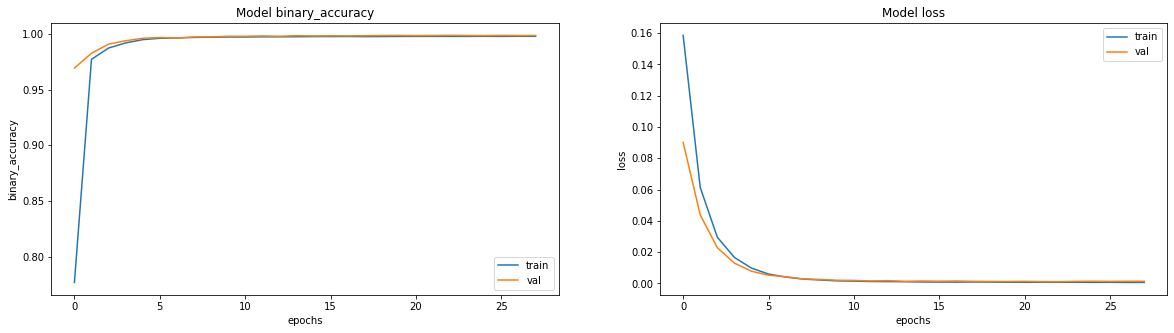

In [ ]:
#Visualizzazione delle statistiche dell'allenamento

from keras import metrics
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
ax = ax.ravel()
#for i, metric in enumerate(['binary_accuracy','loss','recall_2','precision_2']):
for i, metric in enumerate(['binary_accuracy','loss']):
    ax[i].plot(model.history.history[metric])
    ax[i].plot(model.history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

## Prediction 2D

In [ ]:
model = load_model(current_dir+'/2D_Unet.h5', compile= False)

### Funzioni

In [ ]:
def preprocessing(data_itk, n, volumes_info, is_label= False):
  if is_label:
    # Preprocessing per la rete 2D: ricampionamento sul piano xy a (1,1) mm/px
    data_out_itk = resample_image(data_itk, out_spacing=(1.0, 1.0),  out_size=(384,384), is_label=True)  
    data_out = sitk_image_to_data(data_out_itk)
  else:
    # Riempio il dizionario con le informazioni relative al volume 
    volumes_info = dict_fill(data_itk, volumes_info, n)
    # Preprocessing per la rete 2D: HU clipping, min-max Scaling, rescaling su 0-255, ricampionamento sul piano xy a (1,1) mm/px
    original_spacing = data_itk.GetSpacing()
    data_np = sitk_image_to_data(data_itk)
    data_np = hu_clip(data_np, -100, 400)
    data_np = scale(data_np)
    data_out_itk = data_to_sitk_image(data_np, spacing=original_spacing,is_2D = True)
    data_out_itk = resample_image(data_out_itk, out_spacing=(1.0, 1.0), out_size=(384,384)) 
    # Riempio il dizionario con le informazioni relative al preprocessing effettuato sul volume
    volumes_info = dict_fill(data_out_itk, volumes_info,n, data_itk_prep = True)  
  return data_out

In [ ]:
def to_original_spacing(data, volumes_train_info, n):
    original_spacing = volumes_train_info["{}".format(n)]['original_spacing']
    original_size = volumes_train_info["{}".format(n)]['original_size']
    
    data_itk = data_to_sitk_image(data_np, spacing = volumes_train_info["{}".format(n)]['spacing_2D'])
    data_itk = resample_image(data_itk, out_spacing = original_spacing, out_size = original_size,  is_label = True, is_prediction=True)
    data_out = sitk_image_to_data(data_itk)
    
    return data_out

In [ ]:
def predict_slice(vol_slice, volumes_train_info,n):
    softmax = model_2D.predict(np.expand_dims(vol_slice, axis=0))
    softmax = np.reshape(softmax,(IMG_HEIGHT,IMG_WIDTH,NUM_CLASSES_2D))
    prediction_slice = softmax[:,:,1]   
    
    prediction_slice[prediction_slice<=0.5]=0
    prediction_slice[prediction_slice>0.5]=1
    prediction_slice = prediction_slice.astype(np.uint8)
    return prediction_slice

In [ ]:
def predict(n, folder, volumes_train_info):

  case_id = 'case_' + str(n).zfill(5)
  if folder == 'training':
    volume = np.load(path_train_vol+'/'+case_id+'_imaging.npy')  
  elif folder == 'validation':
    volume = np.load(path_val_vol+'/'+case_id+'_imaging.npy') 

  volume = np.stack((volume,)*3, axis=-1) 
  # predizione
  prediction = np.zeros(volume.shape[0:3], dtype=np.uint8)   # non conta i canali RGB
  for sl in range(0,volume.shape[0]):
    prediction_sl = predict_slice(volume[sl], volumes_train_info, n)
    prediction[sl,:,:] = prediction_sl

  return prediction

### Predict and save

In [ ]:
folder = 'Data'
path_train_vol = "/".join((current_dir,folder,'train_volumes'))
path_train_mask = "/".join((current_dir,folder,'train_masks'))
path_val_vol = "/".join((current_dir,folder,'val_volumes'))
path_val_mask = "/".join((current_dir,folder,'val_masks'))

IMG_WIDTH, IMG_HEIGHT = 384, 384     
IMG_CHANNELS = 3
NUM_CLASSES = 2

In [ ]:
path_training = current_dir+'/'+'training'
train_vol = sorted(os.listdir(path_training))
path_prediction = create_path(current_dir, 'prediction_2D_2')
path_prediction_train = create_path(path_prediction, 'training')

for n, id_ in tqdm(enumerate(train_vol), total=len(train_vol)):  
  seg_auto = predict(n,'training', volumes_train_info)
  np.save("/".join((path_prediction_train,str(id_)+'_auto.npy')), seg_auto)

100%|██████████| 100/100 [20:20<00:00, 12.20s/it]


In [ ]:
path_validation = current_dir+'/'+'validation'
val_vol = sorted(os.listdir(path_validation))
path_prediction = create_path(current_dir, 'prediction_2D_2')
path_prediction_val = create_path(path_prediction, 'validation')

for n, id_ in tqdm(enumerate(val_vol), total=len(val_vol)): 
  seg_auto = predict(n+100,'validation',volumes_val_info)
  np.save("/".join((path_prediction_val,str(id_)+'_auto.npy')), seg_auto)

100%|██████████| 50/50 [10:20<00:00, 12.41s/it]


## Calcolo Metriche (DSC - RVD)

In [ ]:
# Dice Similarity Coefficient (DSC)

def dice(prediction, mask):      
  if not prediction.shape == mask.shape:
    raise ValueError(
      ("La maschera automatica ha forma {} diversa"
        "dalla forma della corrispondente maschera manuale {}").format(prediction.shape, mask.shape))
  intersection = np.sum(mask * prediction)
  size_pred = np.count_nonzero(prediction)            
  size_true = np.count_nonzero(mask)
  dc = (2*intersection) / (size_pred + size_true)
  return dc

# Relative Volume Difference (RVD) 
def rvd(prediction, mask):     
  vol1 = np.count_nonzero(prediction)
  vol2 = np.count_nonzero(mask)  
  if 0 == vol2:
    raise RuntimeError('La maschera manuale non contiene alcun oggetto binario (o alcun positivo)')  
  return (vol1 - vol2) / float(vol2)

* Calcolo DSC e RVD - Validation Set

In [ ]:
folder = 'Data'
path_train_vol = "/".join((current_dir,folder,'train_volumes'))
path_train_mask = "/".join((current_dir,folder,'train_masks'))
path_val_vol = "/".join((current_dir,folder,'val_volumes'))
path_val_mask = "/".join((current_dir,folder,'val_masks'))  

In [ ]:
DSC_train_vol = []
RVD_train_vol = []

train_vol= sorted(os.listdir(current_dir+'/'+'training'))
for n, id_ in tqdm(enumerate(train_vol), total=len(train_vol)):   
  DSC_slice = []

  # caricamento del volume e delle maschere manuali
  volume_original = np.load(path_train_vol+'/'+id_+'_imaging.npy')
  volume_original = np.stack((volume_original,)*3, axis=-1)
  
  mask_manual = np.load(path_train_mask+'/'+id_+'_segmentation.npy')
  mask_manual[mask_manual>=1] = 1
  mask_manual[mask_manual<1] = 0
  mask_auto_vol = np.load(path_prediction_train+'/'+id_+'_auto.npy')
  mask_auto_vol = to_original_spacing(mask_auto_vol, volumes_train_info, n)
  mask_manual = to_original_spacing(mask_manual, volumes_train_info, n)
  for sl in range(0,len(mask_auto_vol)): 
    if np.count_nonzero(mask_auto_vol[sl])!=0 or np.count_nonzero(mask_manual[sl])!=0: 
      # calcolo il DS per ciascuna slice appartenente ad un volume
      temp_dice = dice(mask_auto_vol[sl], mask_manual[sl])
      DSC_slice.append(temp_dice)              
    
  DSC_train_vol.append(sum(DSC_slice)/len(DSC_slice)) 
  RVD_train_vol.append(rvd(mask_auto_vol,mask_manual))

DSC_train = sum(DSC_train_vol)/len(DSC_train_vol)
RVD_train = sum(RVD_train_vol)/len(RVD_train_vol)

100%|██████████| 100/100 [07:26<00:00,  4.47s/it]


In [ ]:
temp = np.asarray(DSC_train_vol)
index_less_80 = np.where(temp<0.80)
index_less_70 = np.where(temp<0.70)
index_less_60 = np.where(temp<0.60)

print(tabulate([['DSC', DSC_train*100], ['RVD', RVD_train], ['DSC casi < 60%', *index_less_60], ['DSC casi < 70%', *index_less_70], ['DSC casi < 80%', *index_less_80]], headers=['Training Set', '']))

* Calcolo DSC e RVD - Validation Set

In [ ]:
# Calcolo Dice Score - Validation Set
DSC_val_vol = []
RVD_val_vol = []

val_vol= sorted(os.listdir(current_dir+'/'+'validation'))
for n, id_ in tqdm(enumerate(val_vol), total=len(val_vol)):   
  DSC_slice = []

  # caricamento del volume e delle maschere manuali
  volume_original = np.load(path_val_vol+'/'+id_+'_imaging.npy')
  volume_original = np.stack((volume_original,)*3, axis=-1)
  
  mask_manual = np.load(path_val_mask+'/'+id_+'_segmentation.npy')
  mask_manual[mask_manual>=1] = 1
  mask_manual[mask_manual<1] = 0

  mask_auto_vol = np.load(path_prediction_val+'/'+id_+'_auto.npy')
  mask_auto_vol = to_original_spacing(mask_auto_vol, volumes_val_info, n)
  mask_manual = to_original_spacing(mask_manual, volumes_val_info, n)

  for sl in range(0,len(mask_auto_vol)): 
    if np.count_nonzero(mask_auto_vol[sl])!=0 or np.count_nonzero(mask_manual[sl])!=0: 
      temp_dice = dice(mask_auto_vol[sl], mask_manual[sl])
      DSC_slice.append(temp_dice) 

  DSC_val_vol.append(sum(DSC_slice)/len(DSC_slice)) 
  RVD_val_vol.append(rvd(mask_auto_vol,mask_manual))

DSC_val = sum(DSC_val_vol)/len(DSC_val_vol)
RVD_val = sum(RVD_val_vol)/len(RVD_val_vol)


100%|██████████| 50/50 [03:19<00:00,  4.00s/it]


In [ ]:
temp = np.asarray(DSC_val_vol)
index_less_80 = np.where(temp<0.80)
index_less_70 = np.where(temp<0.70)
index_less_60 = np.where(temp<0.60)

print(tabulate([['DSC', DSC_val*100], ['RVD', RVD_val], ['DSC casi < 60%', *index_less_60], ['DSC casi < 70%', *index_less_70], ['DSC casi < 80%', *index_less_80]], headers=['Validation Set', '']))